<a href="https://www.kaggle.com/ritvik1909/transformers-for-text-classification?scriptVersionId=80376756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model, utils, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=19)
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

In [3]:
seq_len = 512
batch_size = 8
transformer = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(transformer)
encoder = TFAutoModel.from_pretrained(transformer)

input_ids = L.Input(shape=(seq_len,), dtype=tf.int32, name='input_ids')
input_attention_mask = L.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')

embeddings = encoder.roberta([input_ids, input_attention_mask])[0]
pooled = L.GlobalAveragePooling1D()(embeddings)
outputs = L.Dense(20)(pooled)

model = Model(inputs=[input_ids, input_attention_mask], outputs=outputs)
model.compile(optimizer=optimizers.Adam(lr=1e-5), loss=losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilroberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 82118400    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           roberta[0][0]                

In [5]:
tokenized_inputs_train = tokenizer(
    X_train.values.tolist(), max_length=seq_len, truncation=True, padding='max_length', return_tensors='tf'
)
tokenized_inputs_valid = tokenizer(
    X_valid.values.tolist(), max_length=seq_len, truncation=True, padding='max_length', return_tensors='tf'
)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_inputs_train), list(y_train.values)))
valid_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_inputs_valid), list(y_valid.values)))

In [7]:
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True, min_delta=1e-4)

history = model.fit(
    train_dataset.shuffle(1024, seed=19).batch(batch_size), validation_data=valid_dataset.shuffle(1024, seed=19).batch(batch_size), 
    batch_size=batch_size, callbacks=[rlp, es], epochs=20
).history

Epoch 1/20
2121/2121 [==============================] - 646s 301ms/step - loss: 1.2208 - accuracy: 0.6183 - val_loss: 0.4106 - val_accuracy: 0.8684
Epoch 2/20
2121/2121 [==============================] - 638s 301ms/step - loss: 0.3443 - accuracy: 0.8913 - val_loss: 0.3099 - val_accuracy: 0.9093
Epoch 3/20
2121/2121 [==============================] - 638s 301ms/step - loss: 0.2052 - accuracy: 0.9342 - val_loss: 0.3084 - val_accuracy: 0.9109
Epoch 4/20
2121/2121 [==============================] - 637s 300ms/step - loss: 0.1323 - accuracy: 0.9580 - val_loss: 0.2889 - val_accuracy: 0.9225
Epoch 5/20
2121/2121 [==============================] - 638s 301ms/step - loss: 0.0865 - accuracy: 0.9710 - val_loss: 0.3011 - val_accuracy: 0.9374

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-08.
Epoch 6/20
2121/2121 [==============================] - 639s 301ms/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.2734 - val_accuracy: 0.9432
Epoch 7/20
2121/2121 [=========

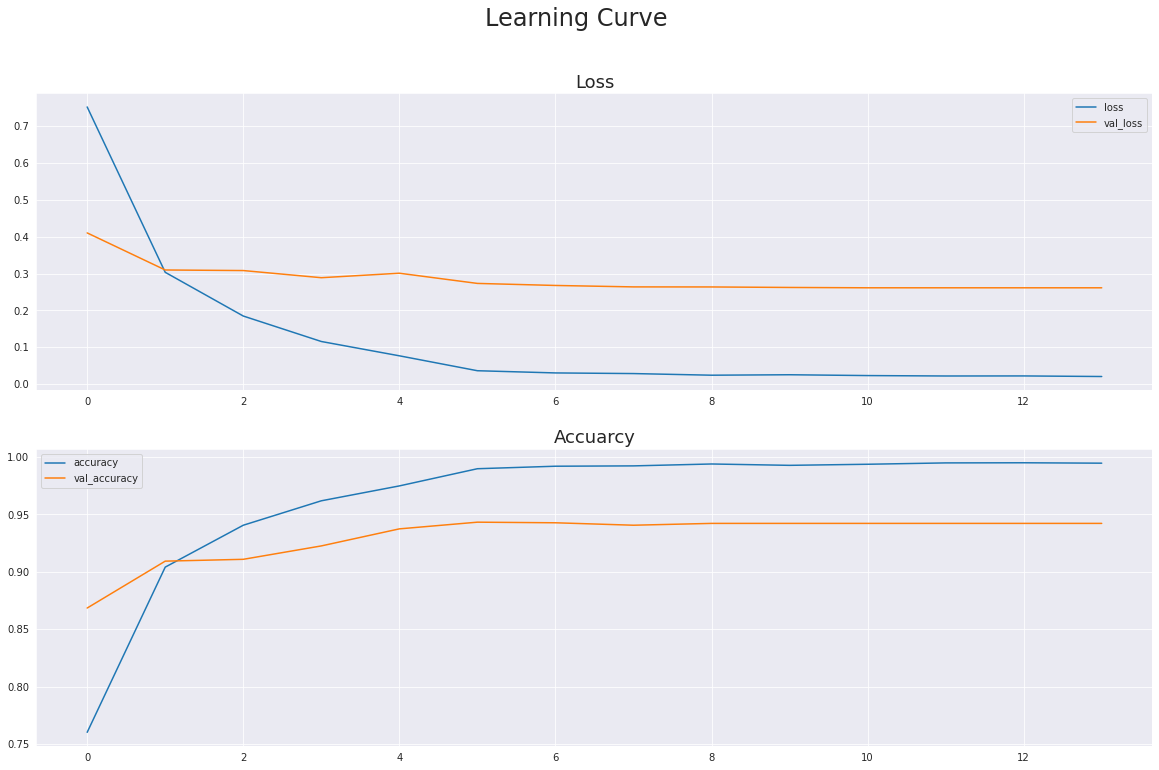

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

history = pd.DataFrame(history)
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
fig.suptitle('Learning Curve', fontsize=24)
history[['loss', 'val_loss']].plot(ax=ax[0])
history[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Loss', fontsize=18)
ax[1].set_title('Accuarcy', fontsize=18);